# Decision Tree Classifier

Classify these three datasets:
- [Letter Recognition](https://archive.ics.uci.edu/dataset/59/letter+recognition)
- [Adult](https://archive.ics.uci.edu/dataset/2/adult)
- [Mushroom](https://archive.ics.uci.edu/dataset/73/mushroom)

using Decision Tree Algorithm

### Load the Dataset

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

def load_dataset(dataset_name):
    dataset = fetch_ucirepo(id=dataset_name)  # Fetch dataset
    df = pd.DataFrame(dataset.data.features)
    df['target'] = dataset.data.targets
    return df

In [2]:
df_letter = load_dataset(59) 
df_adult = load_dataset(2)        
df_mushroom = load_dataset(73)

### Check For Missing Values


In [3]:
print("Letter row count:\n", df_letter.shape[0])
print("Letter Recognition missing values:\n", df_letter.isnull().sum())

Letter row count:
 20000
Letter Recognition missing values:
 x-box     0
y-box     0
width     0
high      0
onpix     0
x-bar     0
y-bar     0
x2bar     0
y2bar     0
xybar     0
x2ybr     0
xy2br     0
x-ege     0
xegvy     0
y-ege     0
yegvx     0
target    0
dtype: int64


In [4]:
print("Adult row count:\n", df_adult.shape[0])
print("Adult missing values:\n", df_adult.isnull().sum())

Adult row count:
 48842
Adult missing values:
 age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
target              0
dtype: int64


In [5]:
print("Mushroom row count:\n", df_mushroom.shape[0])
print("Mushroom missing values:\n", df_mushroom.isnull().sum())

Mushroom row count:
 8124
Mushroom missing values:
 cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
target                         0
dtype: int64


We can see that Letter Dataset doesn't have any missing value. The Mushroom Dataset has some missing values in the stalk-root column. At the same time, the Adult Dataset also has some missing values in the workplace, occupation, and native-country columns. Let's analyse the missingness of the data graphically.


<Axes: >

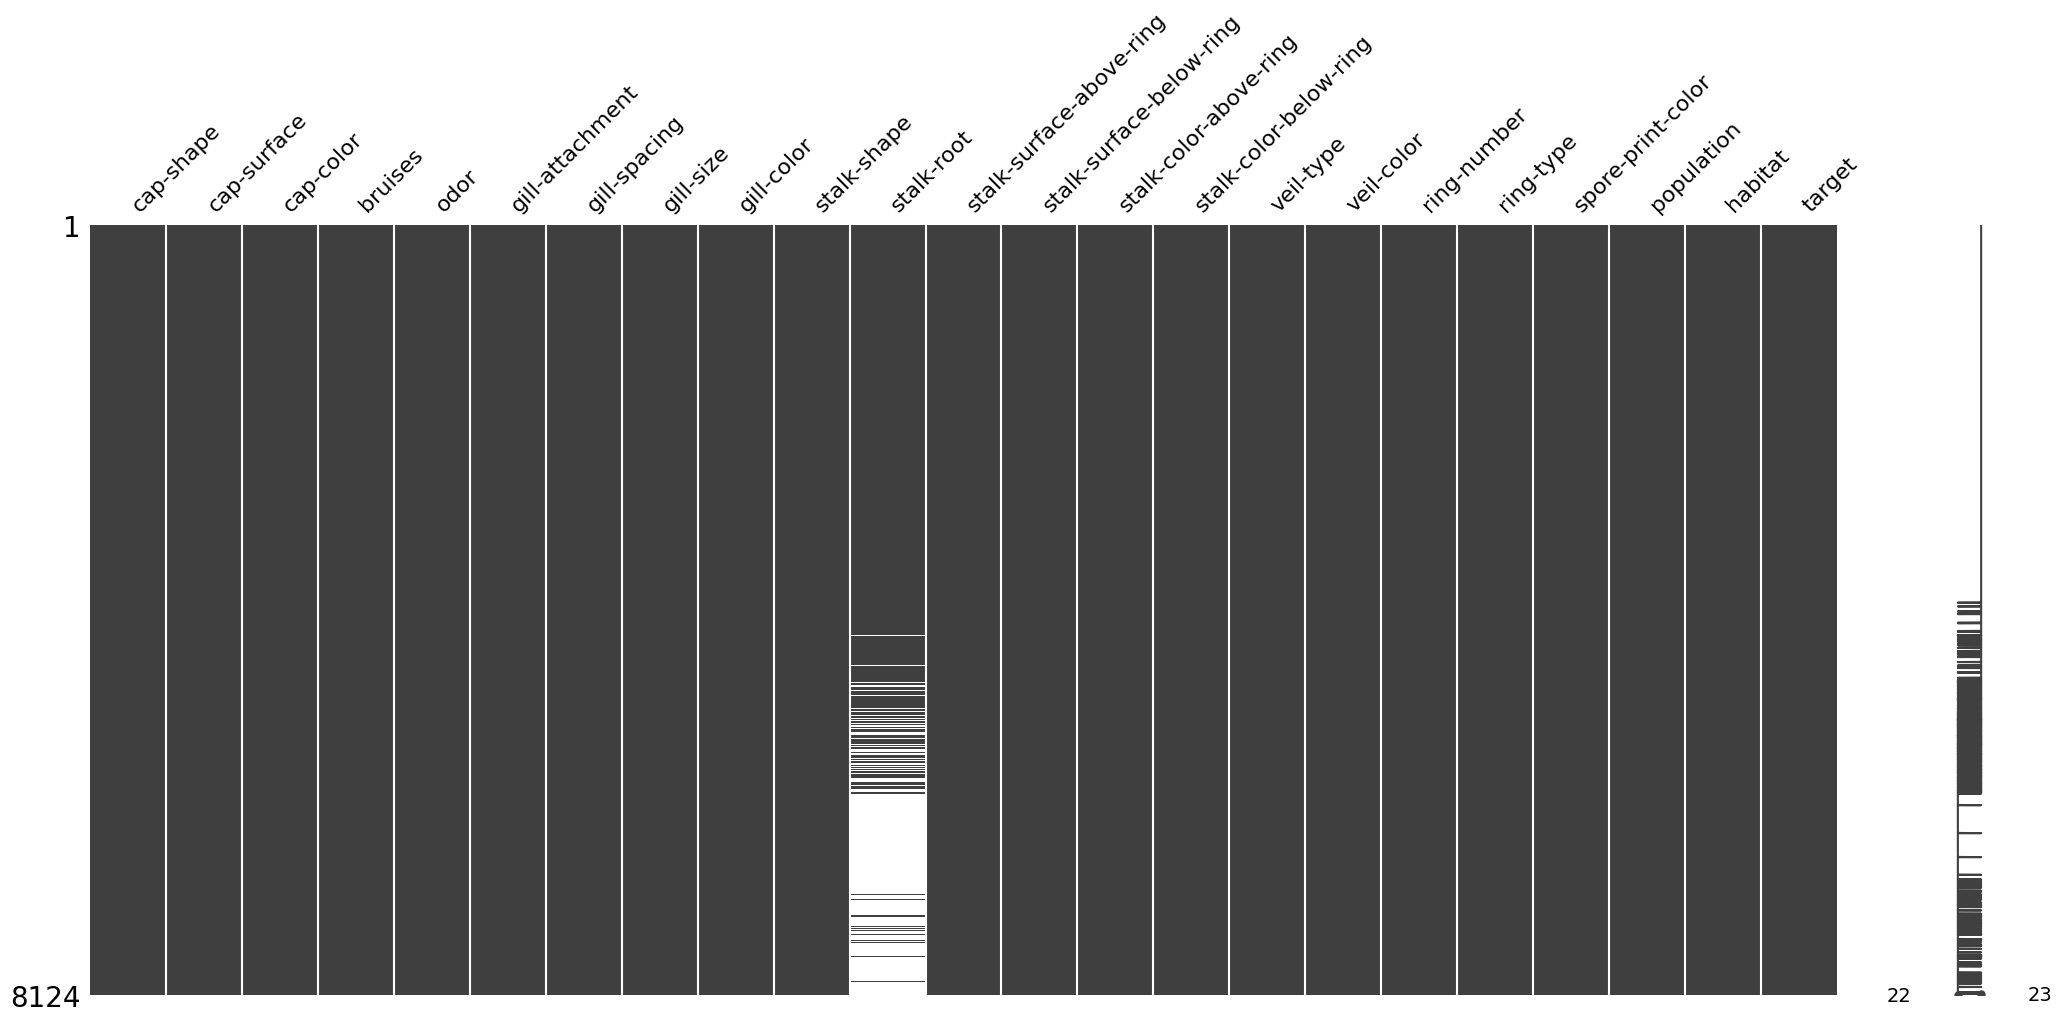

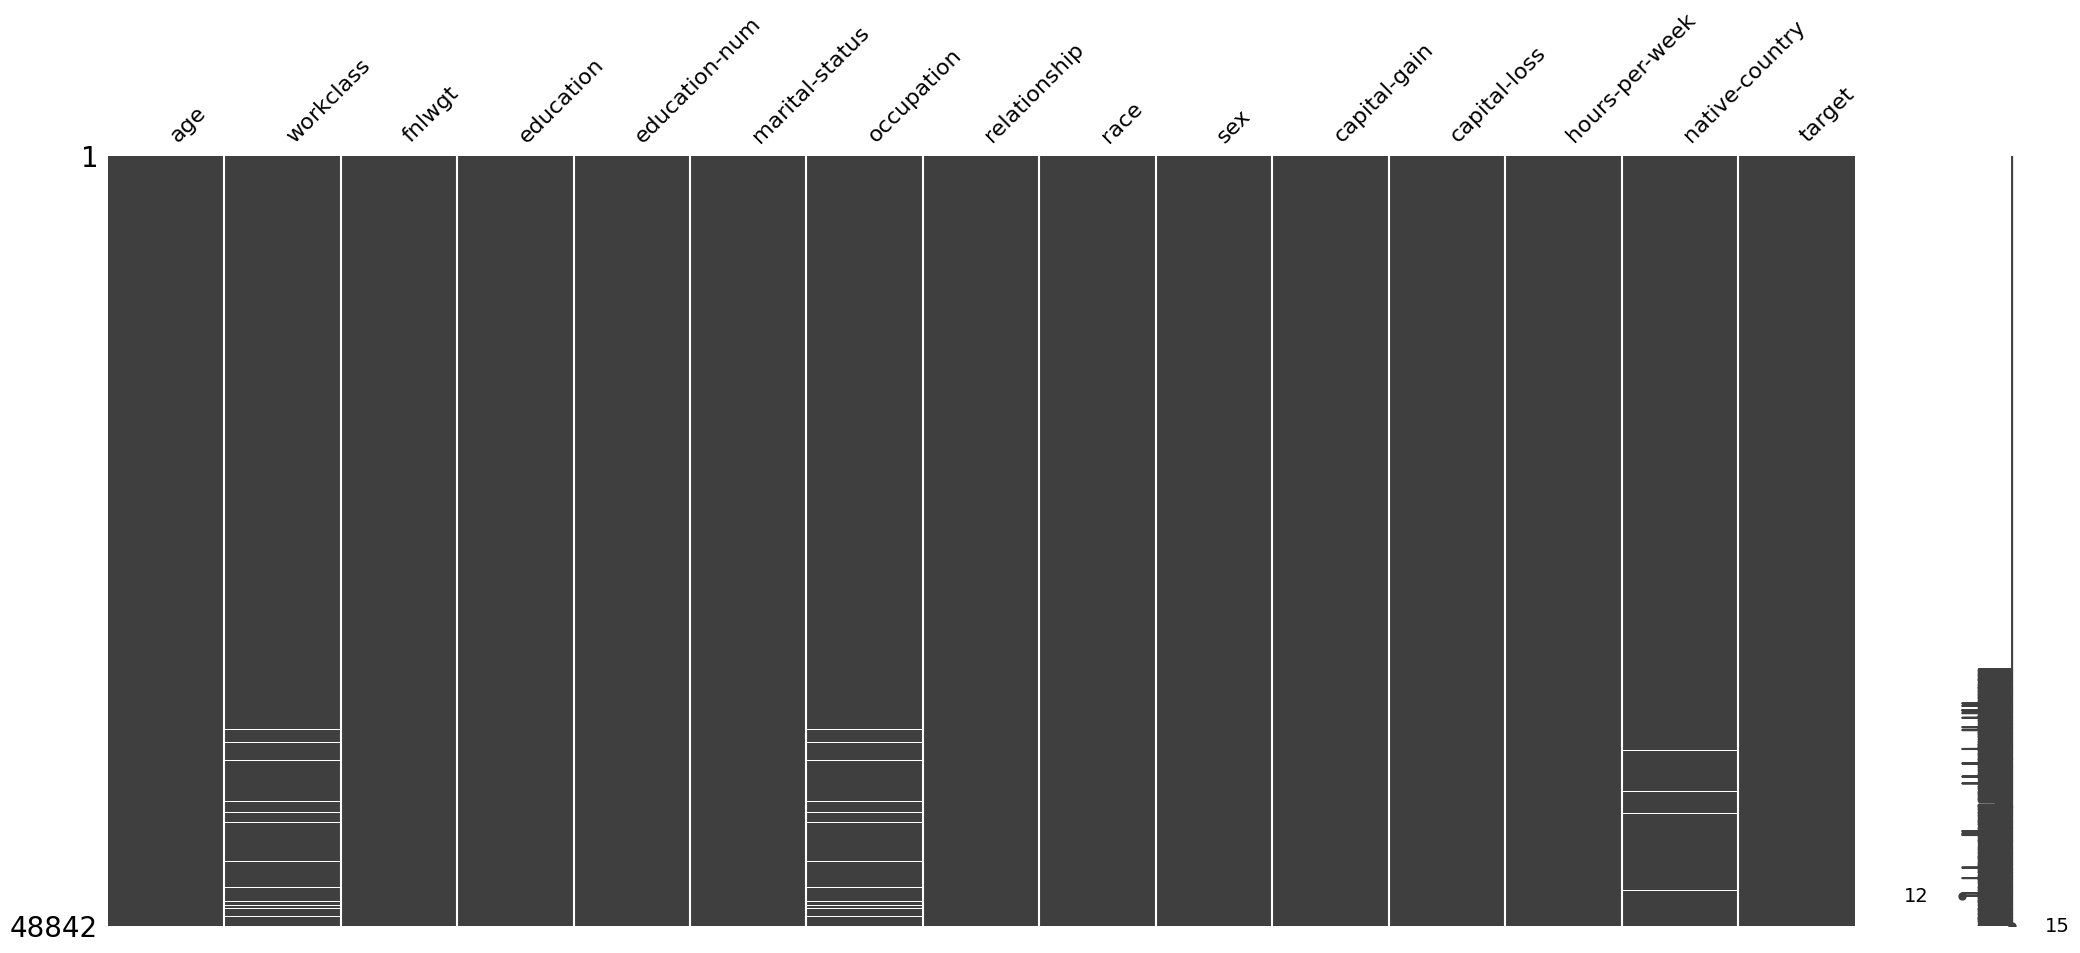

In [6]:
import missingno as msno
msno.matrix(df_mushroom)
msno.matrix(df_adult)

The white parts of the plot indicate missing values. The Stalk-Root columns have a lot of missing values. This could be a case of Missing at Random (MAR) as we cannot directly observe the reason for the missingness of data in the column. On the other hand, in the adult dataset, it seems there is a relationship between the missing values in the workclass and occupation columns. Let's check it using a heat map. 

<Axes: >

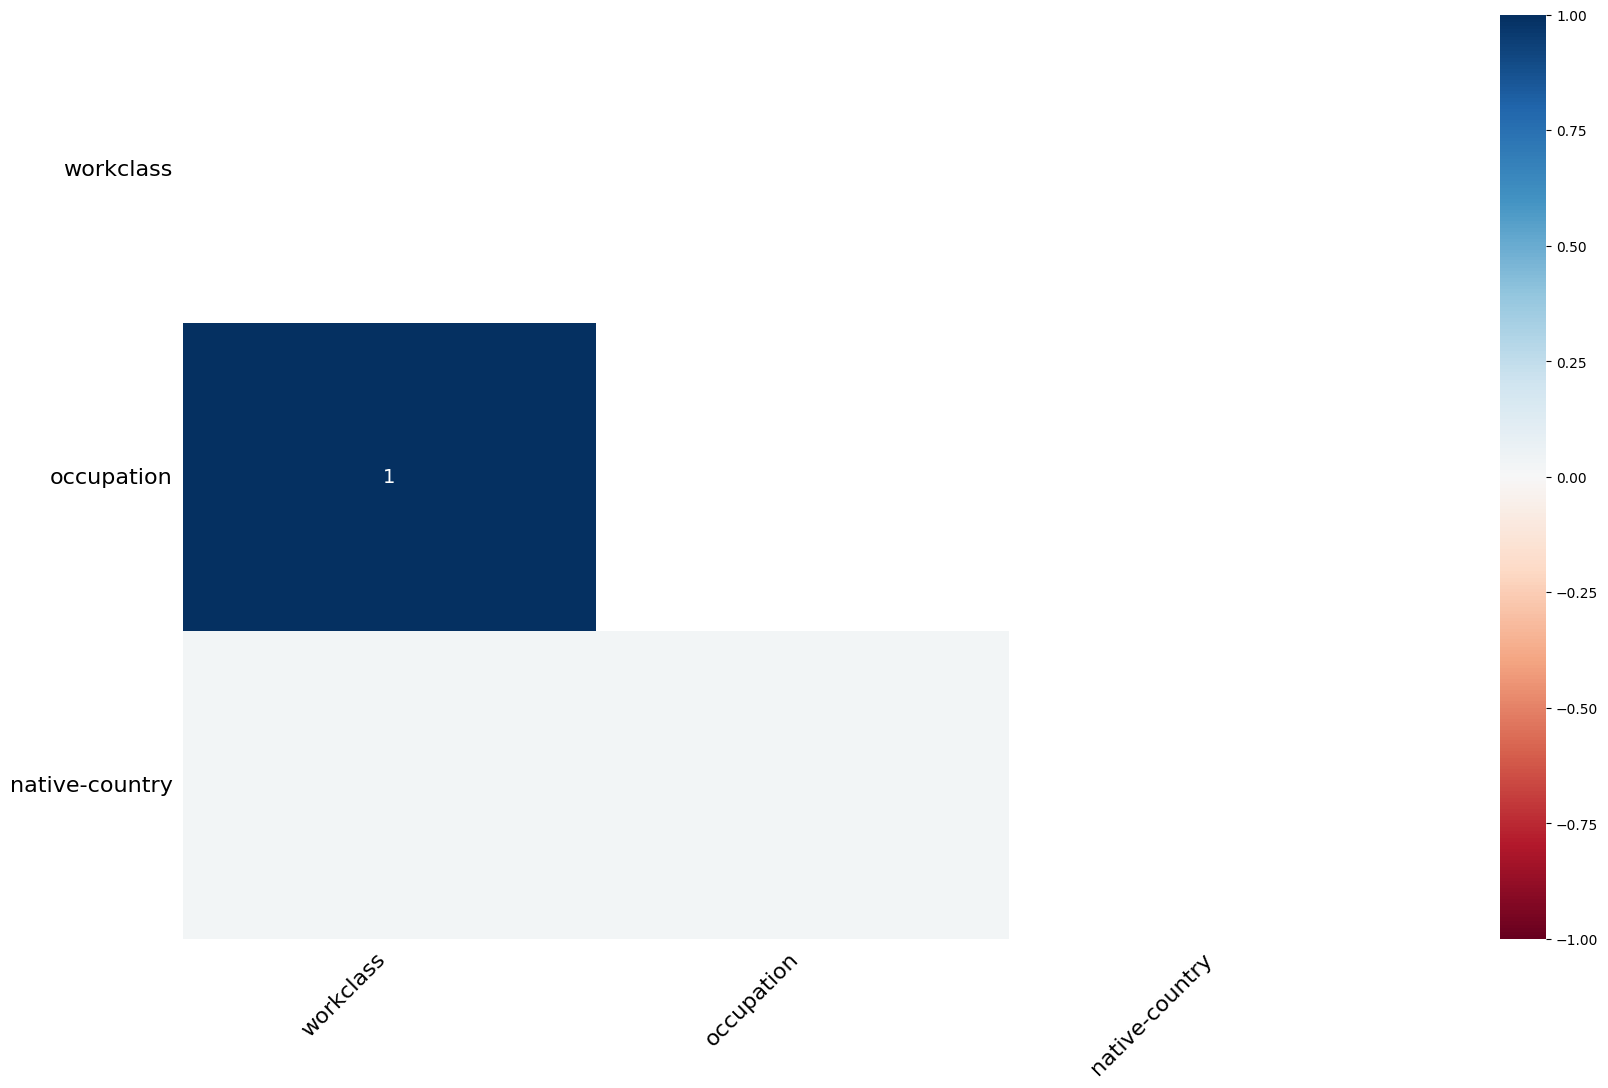

In [7]:
msno.heatmap(df_adult)

As shown is the heatmap, There is a high correlation between those two columns. This could be also the case of MAR as the missingness depends on the observed data.

### Impute Missing Value


In [8]:
print(df_adult[['occupation', 'workclass', 'native-country']].info())
print(df_mushroom[['stalk-root']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   occupation      47876 non-null  object
 1   workclass       47879 non-null  object
 2   native-country  48568 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   stalk-root  5644 non-null   object
dtypes: object(1)
memory usage: 63.6+ KB
None


We can see that the type of features with missing values is an object, a categorical data type. So, we can't replace the missing value with mean or median as they are not numbers. 

Several imputation methods can work with categorical data. The most common one is Mode imputation, which replaces missing values with the most frequent category. We cannot use Mode Imputation in this case because the missing data is not Missing Completely at Random (MCAR). This will result in biased estimates if we use this method.

Therefore, I choose the MICE Imputation method to impute the data. MICE, which stands for Multiple Imputation by Chained Equations, is an advanced imputation method that fills in missing values using predictive modeling. Instead of replacing missing values with a single statistic value like mean, median, or mode, MICE  Builds a predictive model for each variable with missing values. Then, it uses other available features to estimate the missing values iteratively. After that, the process is repeated multiple times to refine the imputations. This method is suitable for MAR data. MICE keeps correlations and dependencies between features intact.

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def impute_dataset_mice(df):
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    for col in df.columns:
        if df[col].isnull().sum() > 0:
                mice_imputer = IterativeImputer()
                df[col] = mice_imputer.fit_transform(df[[col]])
    return df


In [10]:
df_adult['target'] = df_adult['target'].replace({'>50K': '>50K.', '<=50K.': '<=50K'})

df_mushroom_mice = df_mushroom.copy()
df_mushroom_mice = impute_dataset_mice(df_mushroom_mice)

df_adult_mice = df_adult.copy()
df_adult_mice = impute_dataset_mice(df_adult_mice)

df_letter_encoded = df_letter.copy()
for col in df_letter_encoded.select_dtypes(include=['object']).columns:
        df_letter_encoded[col] = LabelEncoder().fit_transform(df_letter_encoded[col])

### Implement the Decision Tree Model

In [11]:
from sklearn.model_selection import train_test_split
def split_dataset(df):
    X = df.drop(columns=['target'])
    y = df['target']
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train_letter, X_test_letter, y_train_letter, y_test_letter = split_dataset(df_letter_encoded)

X_train_adult_mice, X_test_adult_mice, y_train_adult_mice, y_test_adult_mice = split_dataset(df_adult_mice)

X_train_mushroom_mice, X_test_mushroom_mice, y_train_mushroom_mice, y_test_mushroom_mice = split_dataset(df_mushroom_mice)

In [13]:
from collections import Counter
import math
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_importances_ = None  # To store feature importance

    def entropy(self, y):
        """Compute entropy of labels"""
        counts = np.bincount(y)
        probs = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def best_split(self, X, y):
        """Find best split for dataset"""
        best_gain = 0
        best_feature, best_value = None, None
        base_entropy = self.entropy(y)

        for feature in range(X.shape[1]):
            values = np.unique(X[:, feature])
            for val in values:
                left_idx = X[:, feature] <= val
                right_idx = ~left_idx
                
                if len(y[left_idx]) < self.min_samples_split or len(y[right_idx]) < self.min_samples_split:
                    continue
                
                left_entropy = self.entropy(y[left_idx])
                right_entropy = self.entropy(y[right_idx])
                weighted_entropy = (len(y[left_idx]) * left_entropy + len(y[right_idx]) * right_entropy) / len(y)
                info_gain = base_entropy - weighted_entropy
                
                if info_gain > best_gain:
                    best_gain, best_feature, best_value = info_gain, feature, val

        return best_feature, best_value, best_gain

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        if len(set(y)) == 1 or depth == self.max_depth:
            return Counter(y).most_common(1)[0][0]

        feature, value, gain = self.best_split(X, y)
        if feature is None:
            return Counter(y).most_common(1)[0][0]

        left_idx = X[:, feature] <= value
        right_idx = ~left_idx

        return {
            'feature': feature,
            'value': value,
            'gain': gain,
            'left': self.build_tree(X[left_idx], y[left_idx], depth+1),
            'right': self.build_tree(X[right_idx], y[right_idx], depth+1)
        }

    def fit(self, X, y):
        """Train the decision tree"""
        self.tree = self.build_tree(X.to_numpy(), y.to_numpy())
        self._calculate_feature_importances(X.shape[1])

    def _calculate_feature_importances(self, n_features):
        """Calculate feature importance based on    information gain"""
        self.feature_importances_ = np.zeros(n_features)
        self._traverse_tree(self.tree)
        self.feature_importances_ /= np.sum(self.feature_importances_)  # Normalize

    def _traverse_tree(self, node):
        """Traverse the tree and accumulate feature importance"""
        if isinstance(node, dict):
            self.feature_importances_[node['feature']] += node['gain']
            self._traverse_tree(node['left'])
            self._traverse_tree(node['right'])

    def predict_sample(self, tree, sample):
        """Predict for a single sample"""
        if not isinstance(tree, dict):
            return tree
        return self.predict_sample(tree['left'], sample) if sample[tree['feature']] <= tree['value'] else self.predict_sample(tree['right'], sample)

    def predict(self, X):
        """Predict for multiple samples"""
        return np.array([self.predict_sample(self.tree, sample) for sample in X.to_numpy()])
    
    def get_params(self, deep=True):
        """Return hyperparameters for compatibility with scikit-learn"""
        return {"max_depth": self.max_depth, "min_samples_split": self.min_samples_split}

    def set_params(self, **params):
        """Set hyperparameters for compatibility with scikit-learn"""
        for key, value in params.items():
            setattr(self, key, value)
        return self

In this case, I use a pre-pruning decision tree because it is simpler to implement as we just need to specify the parameter. It has faster training time, so it's better for large datasets. As we know, the Adult dataset has 48842 rows, so it will take a long time to use a post-pruned tree.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import time

def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):
    models = {
        "Decision Stump": DecisionTree(max_depth=1), 
        "Unpruned Tree": DecisionTree(max_depth=None),
        "Pre-Pruned Tree": DecisionTree(max_depth=5, min_samples_split=10)
        #Set max_depth to 5 and min_samples_split to 10 because it provides a good balance between complexity and performance
    }
    
    print(f"\n--- Evaluating Models on {dataset_name} ---")
    
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")

        print(f"{name}: Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}, Training Time = {training_time:.4f}s")

In [15]:
# Evaluate all datasets
train_and_evaluate(X_train_letter, y_train_letter, X_test_letter, y_test_letter, "Letter Recognition")

train_and_evaluate(X_train_adult_mice, y_train_adult_mice, X_test_adult_mice, y_test_adult_mice, "Adult MICE")

train_and_evaluate(X_train_mushroom_mice, y_train_mushroom_mice, X_test_mushroom_mice, y_test_mushroom_mice, "Mushroom MICE")



--- Evaluating Models on Letter Recognition ---
Decision Stump: Accuracy = 0.0650, F1-score = 0.0094, Training Time = 0.1095s
Unpruned Tree: Accuracy = 0.8750, F1-score = 0.8750, Training Time = 3.7260s
Pre-Pruned Tree: Accuracy = 0.5080, F1-score = 0.5018, Training Time = 0.5198s

--- Evaluating Models on Adult MICE ---
Decision Stump: Accuracy = 0.7589, F1-score = 0.6549, Training Time = 23.3753s
Unpruned Tree: Accuracy = 0.8122, F1-score = 0.8131, Training Time = 88.9989s
Pre-Pruned Tree: Accuracy = 0.8487, F1-score = 0.8374, Training Time = 63.6908s

--- Evaluating Models on Mushroom MICE ---
Decision Stump: Accuracy = 0.7218, F1-score = 0.6947, Training Time = 0.0170s
Unpruned Tree: Accuracy = 1.0000, F1-score = 1.0000, Training Time = 0.0605s
Pre-Pruned Tree: Accuracy = 0.9772, F1-score = 0.9772, Training Time = 0.0570s


Based on the result, we can see that for the Letter Dataset, Unpruned Tree model return the best Accuracy and F1-Score, same with Mushroom Dataset. While Adult Dataset get best result from the Pre-pruned Tree Model. The Mushroom dataset get perfect F1-Score, this might be the case of overfitting. Let's check it in the next step.

### Select optimal hyperparameters and Evaluate Model Performance

To find the optimal hyperparameters, I use cross-validation because it uses the entire dataset and evaluates the model performance on different subsets of data. It uses multiple splits and the result will be averaged because, providing a better estimate of how the model will perform. It also avoids the problem of unlucky splits that can happen in the usual train-test split, where the split might not be representative. 

For the Cross Validation, specifically, I will use the method K-Fold Cross-Validation with 5-fold. 5-fold is commonly used because it's balanced between bias and variance.

The Hyperparameters that are going to be tuned are:
- max_depth: Controls the maximum depth of the tree.
- min_samples_split: Controls the minimum number of samples to split a node.  
Those two parameters have the most significant impact on model performance as they directly control overfitting and underfitting.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to perform hyperparameter tuning using GridSearchCV
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10, 20]
    }
    
    dt = DecisionTree()
    grid_search = GridSearchCV(dt, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
     
    return grid_search.best_params_

# Function to evaluate the model with optimal hyperparameters
def evaluate_model(X_train, y_train, X_test, y_test, best_params):
    dt = DecisionTree(**best_params)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return precision, recall, f1

# Running the pipeline for each dataset
def run_pipeline(X_train, y_train, X_test, y_test, dataset_name):
    print(f"\n--- Optimizing Hyperparameters for {dataset_name} ---")
    best_params = tune_hyperparameters(X_train, y_train)
    print(f"Best Params: {best_params}")
    
    precision, recall, f1 = evaluate_model(X_train, y_train, X_test, y_test, best_params)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Example: Running on Letter Recognition dataset
run_pipeline(X_train_letter, y_train_letter, X_test_letter, y_test_letter, "Letter Recognition")
run_pipeline(X_train_adult_mice, y_train_adult_mice, X_test_adult_mice, y_test_adult_mice, "Adult MICE")
run_pipeline(X_train_mushroom_mice, y_train_mushroom_mice, X_test_mushroom_mice, y_test_mushroom_mice, "Mushroom MICE")


--- Optimizing Hyperparameters for Letter Recognition ---
Best Params: {'max_depth': None, 'min_samples_split': 2}
Precision: 0.8760, Recall: 0.8750, F1-score: 0.8750

--- Optimizing Hyperparameters for Adult MICE ---
Best Params: {'max_depth': 10, 'min_samples_split': 5}
Precision: 0.8456, Recall: 0.8516, F1-score: 0.8404

--- Optimizing Hyperparameters for Mushroom MICE ---
Best Params: {'max_depth': 10, 'min_samples_split': 2}
Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


The best model for the Adult Dataset is the Pruned tree with max_depth = 10 and min_samples_split = 5. Similarly, the Mushroom dataset works best in the Pruned Tree model with max_depth = 10 and min_samples_split = 2. The cross-validation result indicates that the F1-Score is also 1.00, which means the model is not overfit; it's just a perfect model for the dataset. 

The Letter dataset has different results. We can see that the best max_depth parameter is None, meaning it uses an Unpruned tree model. This is because the Letter dataset has 26 categories of targets (26 Letters), which need a tree with full depth to classify all the targets successfully.

### Compare the Model 

Based on the evaluation result, we got a conclusion for the metrics score and optimal hyperparameters for each dataset.

| Dataset  | max_depth | min_samples | Precision | Recall | F1-Score |
|----------|-----------|-------------|-----------|--------|----------|
| Letter   | None      | 2           | 0.8760    | 0.8750 | 0.8750   |
| Adult    | 10        | 5           | 0.8456    | 0.8516 | 0.8404   |
| Mushroom | 10        | 2           | 1 .00     | 1.00   | 1.00     |

From that table, we can conclude:

1. For Letter dataset, the best model is the unpruned tree. Because it reaches optimal result when max_depth is none.
2. For Adult dataset, the best model is pruned tree with max_depth set to 10.
3. For Mushroom dataset, the best model is pruned tree with max_depth set to 10 and it got perfect F1-Score with no overfit. 


### Report the p-value

Let's calculate the p-value to check whether performance differences are statistically significant. Statistically significant means that the observed difference in performance is unlikely to have occurred by random chance. It suggests that the observed pattern in the data is likely real and not just noise.

To compare the models' performance, we will use a Paired t-test. The paired t-test compares the mean performance of the models across multiple runs. Because we use cross-validation folds to find the optimal parameters, paired t-tests will be suitable for this as they work best in repeated measures.

In [21]:
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

# Collect performance metrics for each model
def collect_performance_metrics(model, X, y, cv=5):
    """
    Collect performance metrics (accuracy) using cross-validation.
    """
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
    return scores

# Compare two models using a paired t-test
def compare_models(model1_scores, model2_scores):
    """
    Compare two models using a paired t-test.
    """
    t_stat, p_value = ttest_rel(model1_scores, model2_scores)
    return t_stat, p_value

# Define models
models = {
    "Decision Stump": DecisionTree(max_depth=1), 
    "Unpruned Tree": DecisionTree(max_depth=None),
    "Pre-Pruned Tree": DecisionTree(max_depth=10, min_samples_split=5)
}

# Evaluate models on a dataset
def evaluate_models_on_dataset(X, y, dataset_name):
    print(f"\n--- Evaluating Models on {dataset_name} ---")
    
    # Collect performance metrics for each model
    model_scores = {}
    for name, model in models.items():
        scores = collect_performance_metrics(model, X, y)
        model_scores[name] = scores
        print(f"{name}: Mean F1-Score = {scores.mean():.4f}, Std = {scores.std():.4f}")
    
    # Compare models using paired t-tests
    model_names = list(models.keys())
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            model1 = model_names[i]
            model2 = model_names[j]
            t_stat, p_value = compare_models(model_scores[model1], model_scores[model2])
            print(f"\nComparing {model1} vs {model2}:")
            print(f"T-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
            if p_value < 0.05:
                print("The performance difference is statistically significant.")
            else:
                print("The performance difference is not statistically significant.")

# Evaluate models on all datasets
evaluate_models_on_dataset(X_train_letter, y_train_letter, "Letter Recognition")
evaluate_models_on_dataset(X_train_adult_mice, y_train_adult_mice, "Adult MICE")
evaluate_models_on_dataset(X_train_mushroom_mice, y_train_mushroom_mice, "Mushroom MICE")


--- Evaluating Models on Letter Recognition ---
Decision Stump: Mean F1-Score = 0.0104, Std = 0.0011
Unpruned Tree: Mean F1-Score = 0.8500, Std = 0.0084
Pre-Pruned Tree: Mean F1-Score = 0.7961, Std = 0.0040

Comparing Decision Stump vs Unpruned Tree:
T-statistic = -204.9344, p-value = 0.0000
The performance difference is statistically significant.

Comparing Decision Stump vs Pre-Pruned Tree:
T-statistic = -349.9293, p-value = 0.0000
The performance difference is statistically significant.

Comparing Unpruned Tree vs Pre-Pruned Tree:
T-statistic = 14.6447, p-value = 0.0001
The performance difference is statistically significant.

--- Evaluating Models on Adult MICE ---
Decision Stump: Mean F1-Score = 0.6579, Std = 0.0031
Unpruned Tree: Mean F1-Score = 0.8193, Std = 0.0062
Pre-Pruned Tree: Mean F1-Score = 0.8494, Std = 0.0030

Comparing Decision Stump vs Unpruned Tree:
T-statistic = -51.3123, p-value = 0.0000
The performance difference is statistically significant.

Comparing Decision 

Here's the interpretation based on the p-value results across all three datasets:

### **Letter Recognition Dataset**
1. **Decision Stump vs Unpruned Tree**  
   - $$ t = -204.93, p < 0.001 $$  
   → **Unpruned tree is vastly superior** (F1: 0.85 vs 0.01).  

2. **Decision Stump vs Pre-Pruned Tree**  
   - $$ t = -349.93, p < 0.001 $$  
   → **Pre-Pruned tree is also far better** than the stump (F1: 0.796 vs 0.01).  

3. **Unpruned vs Pre-Pruned Tree**  
   - $$ t = 14.64, p < 0.001 $$  
   → **Unpruned tree significantly outperforms pre-pruned** (F1: 0.85 vs 0.796).  


### **Adult MICE Dataset**
1. **Decision Stump vs Unpruned Tree**  
   - $$ t = -51.31, p < 0.001 $$  
   → **Unpruned tree is much better** (F1: 0.819 vs 0.658).  

2. **Decision Stump vs Pre-Pruned Tree**  
   - $$ t = -78.45, p < 0.001 $$  
   → **Pre-Pruned tree is even better** than unpruned (F1: 0.849 vs 0.658).  

3. **Unpruned vs Pre-Pruned Tree**  
   - $$ t = -9.14, p = 0.0008 $$  
   → **Pre-Pruned tree is significantly better** (F1: 0.849 vs 0.819).  


### **Mushroom MICE Dataset**
1. **Decision Stump vs Unpruned Tree**  
   - $$ t = -40.58, p < 0.001 $$  
   → **Unpruned tree is perfect** (F1=1.0 vs 0.709).  

2. **Decision Stump vs Pre-Pruned Tree**  
   - $$ t = -38.42, p < 0.001 $$  
   → **Pre-Pruned tree is near-perfect** (F1=0.999 vs 0.709).  

3. **Unpruned vs Pre-Pruned Tree**  
   - $$ t = 1.37, p = 0.242 $$  
   → **No significant difference** (F1: 1.0 vs 0.999).  


The conclusions are:
- For the Letter Recognition, Unpruned tree dominates the performance.
- Adult Pruned trees outperform unpruned.
- Mushroom MICE: No statistical difference between the performance of unpruned and pruned tree. It means that we can use both model to the Mushroom dataset.

### Analyzing Feature Importance

Feature importance in decision trees is determined based on how much each feature contributes to increasing information gain across all splits in the tree.

In [22]:
def get_top_features(model, feature_names, top_n=3):
    """
    Get the top N most important features from a trained model.
    """
    feature_importance = model.feature_importances_
    sorted_indices = np.argsort(feature_importance)[::-1]  # Sort in descending order
    top_features = [(feature_names[i], feature_importance[i]) for i in sorted_indices[:top_n]]
    return top_features

In [24]:
# Define feature names for each dataset
feature_names_letter = df_letter.drop(columns=['target']).columns
feature_names_adult = df_adult_mice.drop(columns=['target']).columns
feature_names_mushroom = df_mushroom_mice.drop(columns=['target']).columns

# Train models and analyze feature importance
def analyze_feature_importance(X_train, y_train, feature_names, dataset_name):
    print(f"\n--- Feature Importance for {dataset_name} ---")
    
    models = {
        "Decision Stump": DecisionTree(max_depth=1),
        "Unpruned Tree": DecisionTree(max_depth=None),
        "Pre-Pruned Tree": DecisionTree(max_depth=10, min_samples_split=5)
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        top_features = get_top_features(model, feature_names, top_n=3)
        print(f"\n{name}:")
        for feature, importance in top_features:
            print(f"  {feature}: Importance = {importance:.4f}")

# Analyze feature importance for each dataset
analyze_feature_importance(X_train_letter, y_train_letter, feature_names_letter, "Letter Recognition")
analyze_feature_importance(X_train_adult_mice, y_train_adult_mice, feature_names_adult, "Adult MICE")
analyze_feature_importance(X_train_mushroom_mice, y_train_mushroom_mice, feature_names_mushroom, "Mushroom MICE")


--- Feature Importance for Letter Recognition ---

Decision Stump:
  y-ege: Importance = 1.0000
  yegvx: Importance = 0.0000
  xegvy: Importance = 0.0000

Unpruned Tree:
  x-box: Importance = 0.1095
  y-box: Importance = 0.0965
  y2bar: Importance = 0.0922

Pre-Pruned Tree:
  y2bar: Importance = 0.1143
  x-ege: Importance = 0.1041
  x2ybr: Importance = 0.0862

--- Feature Importance for Adult MICE ---

Decision Stump:
  relationship: Importance = 1.0000
  native-country: Importance = 0.0000
  capital-loss: Importance = 0.0000

Unpruned Tree:
  fnlwgt: Importance = 0.4009
  age: Importance = 0.3108
  hours-per-week: Importance = 0.0724

Pre-Pruned Tree:
  capital-loss: Importance = 0.1919
  fnlwgt: Importance = 0.1899
  age: Importance = 0.1799

--- Feature Importance for Mushroom MICE ---

Decision Stump:
  gill-color: Importance = 1.0000
  habitat: Importance = 0.0000
  spore-print-color: Importance = 0.0000

Unpruned Tree:
  bruises: Importance = 0.2108
  habitat: Importance = 0.204

1. In Letter dataset, the most important feature in the unpruned tree model is x-box (horizontal position of box).
2. For adult dataset, most important feature in pre-pruned tree model is capital-loss which is the loss earned on the sale of an asset. 
3. For mushroom dataset, most important feature in pre-pruned tree model is bruises.

### Measuring runtime performance

Let's train the model again using the optimal hyperparameters and count the training time 

In [25]:
def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):
    models = {
        "Decision Stump": DecisionTree(max_depth=1),
        "Unpruned Tree": DecisionTree(max_depth=None),
        "Pre-Pruned Tree": DecisionTree(max_depth=10, min_samples_split=5)
    }
    
    print(f"\n--- Evaluating Models on {dataset_name} ---")
    
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)

        print(f"{name}: Accuracy = {accuracy:.4f}, Training Time = {training_time:.4f}s")

In [26]:
train_and_evaluate(X_train_letter, y_train_letter, X_test_letter, y_test_letter, "Letter Recognition")

train_and_evaluate(X_train_adult_mice, y_train_adult_mice, X_test_adult_mice, y_test_adult_mice, "Adult MICE")

train_and_evaluate(X_train_mushroom_mice, y_train_mushroom_mice, X_test_mushroom_mice, y_test_mushroom_mice, "Mushroom MICE")



--- Evaluating Models on Letter Recognition ---
Decision Stump: Accuracy = 0.0650, Training Time = 0.0707s
Unpruned Tree: Accuracy = 0.8750, Training Time = 3.4467s
Pre-Pruned Tree: Accuracy = 0.8083, Training Time = 1.7723s

--- Evaluating Models on Adult MICE ---
Decision Stump: Accuracy = 0.7589, Training Time = 20.1627s
Unpruned Tree: Accuracy = 0.8122, Training Time = 85.5444s
Pre-Pruned Tree: Accuracy = 0.8516, Training Time = 73.2542s

--- Evaluating Models on Mushroom MICE ---
Decision Stump: Accuracy = 0.7218, Training Time = 0.0168s
Unpruned Tree: Accuracy = 1.0000, Training Time = 0.0596s
Pre-Pruned Tree: Accuracy = 1.0000, Training Time = 0.0578s


Based on the training, we can analyze the results.

- For Training Time Comparison Across Models, Decision Stump is the Fastest to train because it only contains a single-level Tree. On the other hand, Unpruned Tree becomes the slowest to train because it grows the Tree until all leaves are pure or until all possible splits are exhausted. The bigger the dataset size and complexity, the more training time will increase. The pre-pruned Tree performs faster than the unpruned Tree but slower than the stump. The training time reduction is caused by the limitation on depth and minimum sample split.

- Training Time Comparison Across Datasets. Letter Recognition has 20000 rows of data, Adult has 48842, and Mushroom has 8124. Adults have the longest training time, followed by letter recognition, and lastly, the Mushroom has the fastest training time. Based on the result, Training time generally increases with dataset size (number of samples and features). The unpruned tree model becomes the most affected model by dataset size because it explores all possible splits. Meanwhile, decision stump is not really affected by dataset size as it only makes one split.

- Regarding Trade-offs between Accuracy and Computational Efficiency, each model has pros and cons.
1. Decision Stump:
    - Pros: Very fast to train, computationally efficient.
    - Cons: Lower accuracy and F1-score due to its simplicity.
    - Best for scenarios where computational efficiency is critical, and a rough approximation is sufficient.

2. Unpruned Tree:
    - Pros: Highest accuracy and F1-score, as it captures complex patterns in the data.
    - Cons: It is slow to train and computationally expensive.
    - Best for scenarios where accuracy is the top priority and computational resources are not a constraint.

3. Pre-Pruned Tree:
    - Pros: Limiting tree depth and splits reduces accuracy and training time.
    - Cons: Slightly lower accuracy than the unpruned Tree but much faster to train.
    - Best for scenarios where a balance between accuracy and computational efficiency is required.

- In the practical world, a decision stump or pre-pruned Tree may be more beneficial for large datasets due to their lower computational cost. An unpruned tree can be used for small datasets to achieve the highest accuracy without significant computational overhead.